In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import config as cfg
import helper as hp
import metrics as mt
from tqdm.notebook import tqdm

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import catboost as cat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import category_encoders as ce

In [3]:
RANDOM_STATE = 77
hp.seed_everything(RANDOM_STATE)

In [4]:
N_SPLITS = 5

In [5]:
train = pd.read_pickle(cfg.PREPARED_TRAIN_DATA_PATH)
test = pd.read_pickle(cfg.PREPARED_TEST_DATA_PATH)
train, labels = train.drop(cfg.TARGETS, axis=1), train[cfg.TARGETS]

In [6]:
EXCLUDE_COLS = ['wake_up_time', 'sleep_time']
USECOLS = [c for c in train.columns if c not in EXCLUDE_COLS]
GOLDEN_FEATURE = 'regular_medication_intake'
CAT_COLS = cfg.CAT_UNORDERED_COLS
CAT_FEATURES_FILTERED = [c for c in CAT_COLS if c not in EXCLUDE_COLS]

In [7]:
def apply_cat_encoding(cat_encoders: dict, X_train, Y_train, X_val) -> tuple[pd.DataFrame, pd.DataFrame]:
    def _rename_cols(df: pd.DataFrame, target_col: str, encoder_name: str, cols) -> pd.DataFrame:
        rename_map = {}
        for col in cols:
            rename_map[col] = f'{col}_{target_col}_{encoder_name}'
        df = df.rename(columns=rename_map)
        return df

    
    X_cat_train, X_cat_val = [], []
    for encoder_name, encoder in cat_encoders.items():
        cols = encoder.cols
        for target_col in Y_train.columns:
            X_cat_train_enc = encoder.fit_transform(X_train[cols], Y_train[target_col])
            X_cat_train_enc = _rename_cols(X_cat_train_enc, target_col, encoder_name, cols)
            X_cat_train.append(X_cat_train_enc)

            X_cat_val_enc = encoder.transform(X_val[cols])
            X_cat_val_enc = _rename_cols(X_cat_val_enc, target_col, encoder_name, cols)
            X_cat_val.append(X_cat_val_enc)
    return pd.concat([X_train] + X_cat_train, axis=1), pd.concat([X_val] + X_cat_val, axis=1)

In [8]:
cat_encoders = {
    # 'WOE': ce.WOEEncoder(cols=[GOLDEN_FEATURE], random_state=RANDOM_STATE, regularization=2.5),
    # 'TE': ce.TargetEncoder(cols=CAT_COLS)
}

In [9]:
cv = MultilabelStratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

pred_oof = pd.DataFrame(np.zeros(shape=labels.shape), index=labels.index, columns=labels.columns)
pred_test = pd.DataFrame(np.zeros(shape=(len(test), len(cfg.TARGETS))), index=test.index, columns=labels.columns)

models = []

_, X_test = apply_cat_encoding(
        cat_encoders,
        train[USECOLS],
        labels,
        test[USECOLS]
    )

golden_feature_idx = train.columns.tolist().index(GOLDEN_FEATURE)
for train_idx, val_idx in tqdm(cv.split(train, labels), total=N_SPLITS):
    X_train = train.iloc[train_idx][USECOLS]
    Y_train = labels.iloc[train_idx]
    X_val = train.iloc[val_idx][USECOLS]
    Y_val = labels.iloc[val_idx]

    X_train, X_val = apply_cat_encoding(
        cat_encoders,
        X_train,
        Y_train,
        X_val
    )

    clf = cat.CatBoostClassifier(
        iterations=300,
        cat_features=CAT_FEATURES_FILTERED,
        per_float_feature_quantization=f'{golden_feature_idx}:border_count=1024',
        silent=True, 
        loss_function='MultiLogloss')
    
    clf.fit(
        X=X_train, 
        y=Y_train,
        eval_set=[(X_val, Y_val)],
        plot=True)
    models.append(clf)
    
    pred_oof.iloc[val_idx] = clf.predict_proba(X_val)
    pred_test += clf.predict_proba(X_test)
pred_test /= N_SPLITS

  0%|          | 0/5 [00:00<?, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [10]:
thresholds = mt.get_tresholds(labels, pred_oof)
template = pd.DataFrame(np.zeros_like(labels), index=labels.index, columns=labels.columns)
pred_labels = hp.make_prediction(pred_oof, thresholds, template, rename_cols=False)

[0.6905134361660846, 0.7186320706607103, 0.5997604838493859, 0.6570422159363826, 0.7399896041653818]
0.681187562155589 0.049315535307448644


In [25]:
sample_submission = pd.read_csv(cfg.SAMPLE_SUBMISSION_PATH).set_index('ID')
prediction = hp.make_prediction(pred_test, thresholds, sample_submission)

In [26]:
EXPERIMENT_FAMILY_NAME = 'catboost'
EXPERIMENT_NAME = 'eda'

In [27]:
hp.save_submission(prediction, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, '')
hp.save_pred_proba_oof(pred_oof, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, '')
hp.save_pred_proba_test(pred_test, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME, '')

In [11]:
# [0.6908226620100892, 0.7122779103686026, 0.6182928787432762, 0.6540134493248653, 0.7335406626904067]
# 0.681789512627448 0.041213235555196244

In [12]:
print('roc_auc_score', roc_auc_score(labels, pred_oof, average='macro'))
print(classification_report(labels, pred_labels, zero_division=0))

roc_auc_score 0.7073622050882811
              precision    recall  f1-score   support

           0       0.19      0.74      0.30        96
           1       0.23      0.81      0.36       117
           2       0.12      0.71      0.21        86
           3       0.07      0.76      0.13        41
           4       0.70      0.77      0.73       446

   micro avg       0.27      0.76      0.40       786
   macro avg       0.26      0.76      0.35       786
weighted avg       0.47      0.76      0.54       786
 samples avg       0.17      0.39      0.22       786



In [13]:
# roc_auc_score 0.7080234803981791
#               precision    recall  f1-score   support

#            0       0.17      0.83      0.28        96
#            1       0.24      0.78      0.36       117
#            2       0.13      0.73      0.22        86
#            3       0.06      0.88      0.12        41
#            4       0.70      0.76      0.73       446

#    micro avg       0.25      0.77      0.38       786
#    macro avg       0.26      0.80      0.34       786
# weighted avg       0.47      0.77      0.53       786
#  samples avg       0.16      0.39      0.21       786
# # 

In [14]:
fis = []
for clf in models:
    fi = pd.Series(clf.feature_importances_, index=clf.feature_names_)
    fis.append(fi)

<AxesSubplot:>

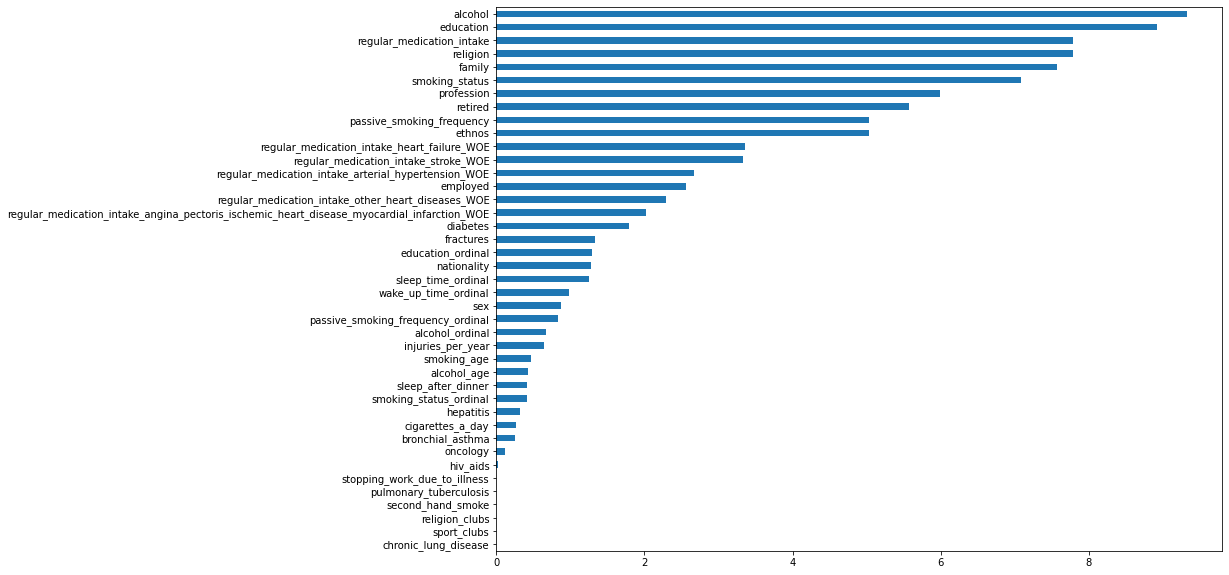

In [15]:
fis[0].sort_values().plot(kind='barh', figsize=(13,10))

<AxesSubplot:>

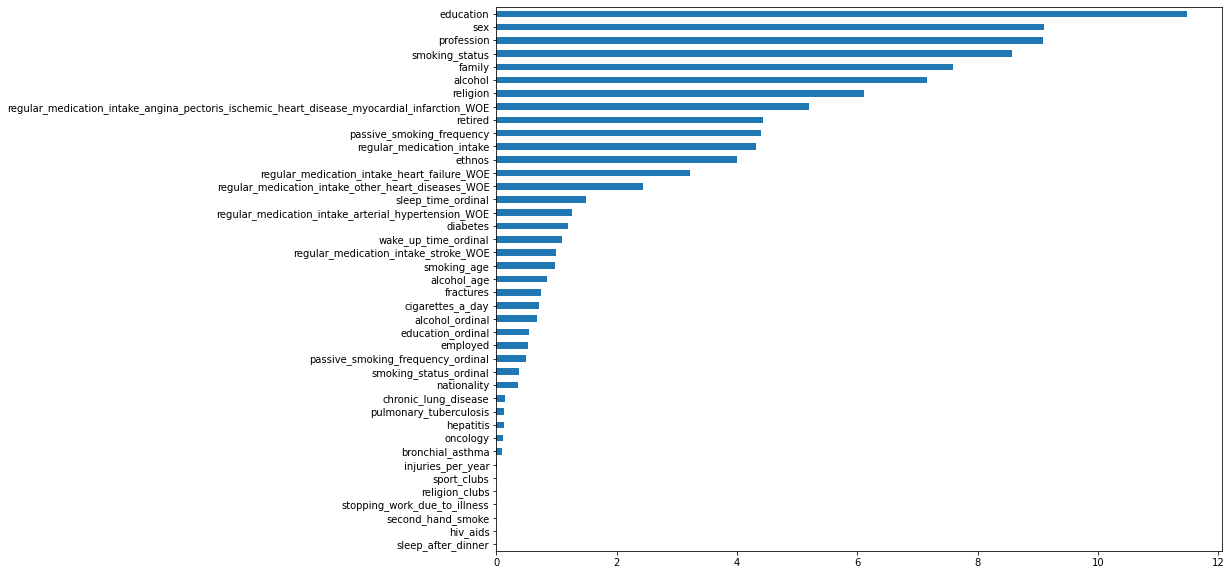

In [16]:
fis[1].sort_values().plot(kind='barh', figsize=(13,10))

<AxesSubplot:>

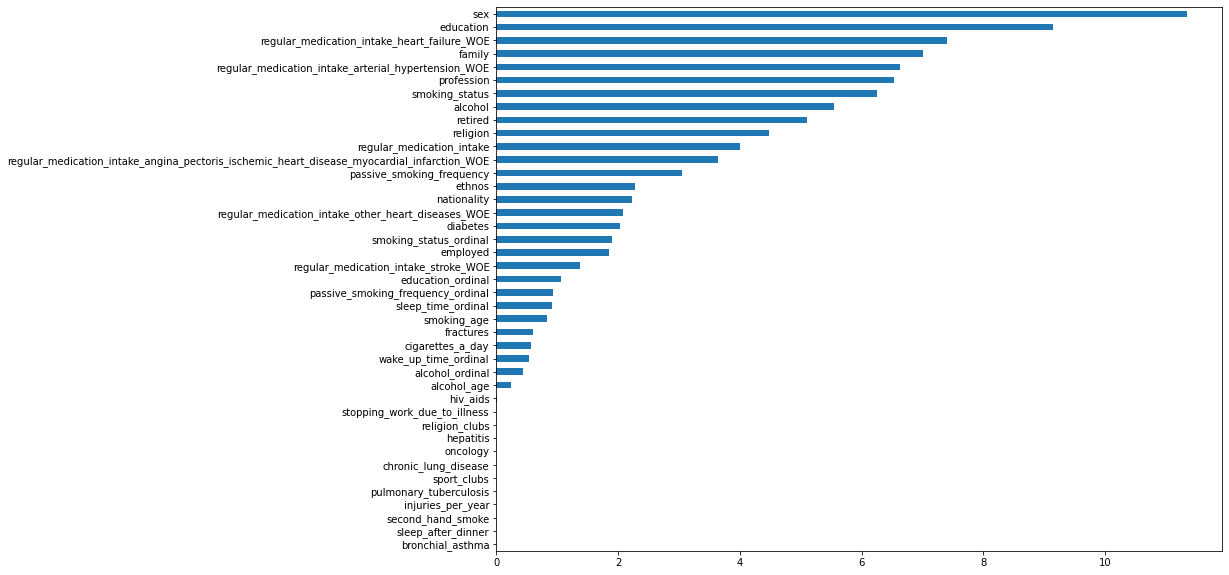

In [17]:
fis[2].sort_values().plot(kind='barh', figsize=(13,10))

<AxesSubplot:xlabel='Percent', ylabel='regular_medication_intake'>

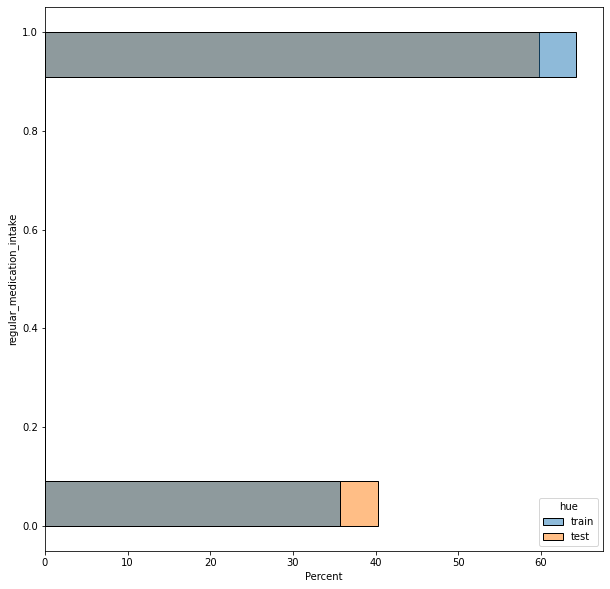

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
col = 'regular_medication_intake'
sns.histplot(
    data=pd.concat([
        train[[col]].assign(hue='train'),
        test[[col]].assign(hue='test'),
        ]),
    y=col,
    common_bins=False, 
    common_norm=False,
    stat='percent',
    hue='hue')

<AxesSubplot:xlabel='Percent', ylabel='sleep_time'>

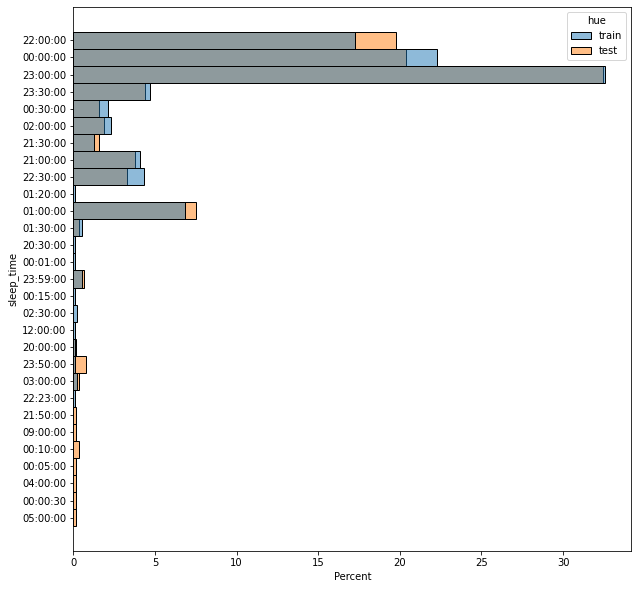

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
col = 'sleep_time'
sns.histplot(
    data=pd.concat([
        train[[col]].assign(hue='train'),
        test[[col]].assign(hue='test'),
        ]),
    y=col,
    common_bins=False, 
    common_norm=False,
    stat='percent',
    hue='hue')

<AxesSubplot:xlabel='Percent', ylabel='family'>

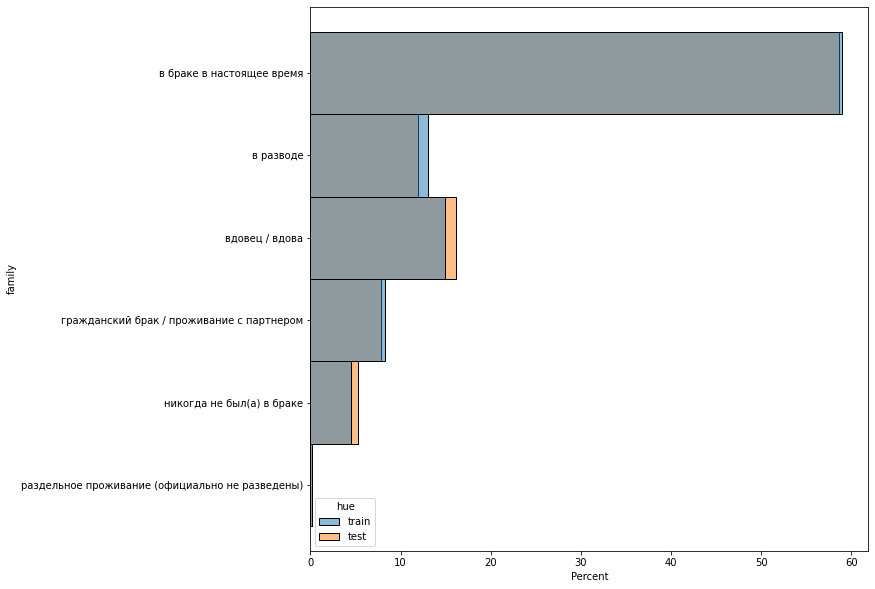

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
col = 'family'
sns.histplot(
    data=pd.concat([
        train[[col]].assign(hue='train'),
        test[[col]].assign(hue='test'),
        ]),
    y=col,
    common_bins=False, 
    common_norm=False,
    stat='percent',
    hue='hue')

<AxesSubplot:xlabel='Percent', ylabel='alcohol'>

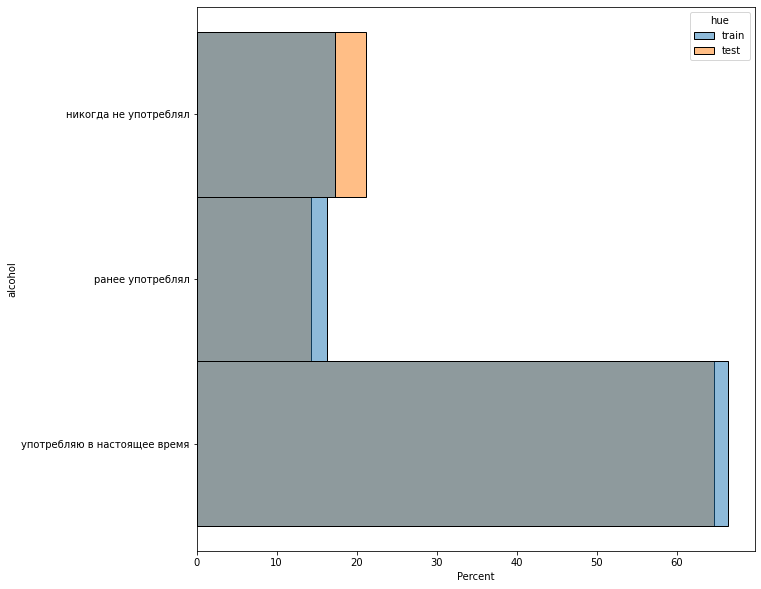

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
col = 'alcohol'
sns.histplot(
    data=pd.concat([
        train[[col]].assign(hue='train'),
        test[[col]].assign(hue='test'),
        ]),
    y=col,
    common_bins=False, 
    common_norm=False,
    stat='percent',
    hue='hue')

<AxesSubplot:xlabel='Percent', ylabel='smoking_status'>

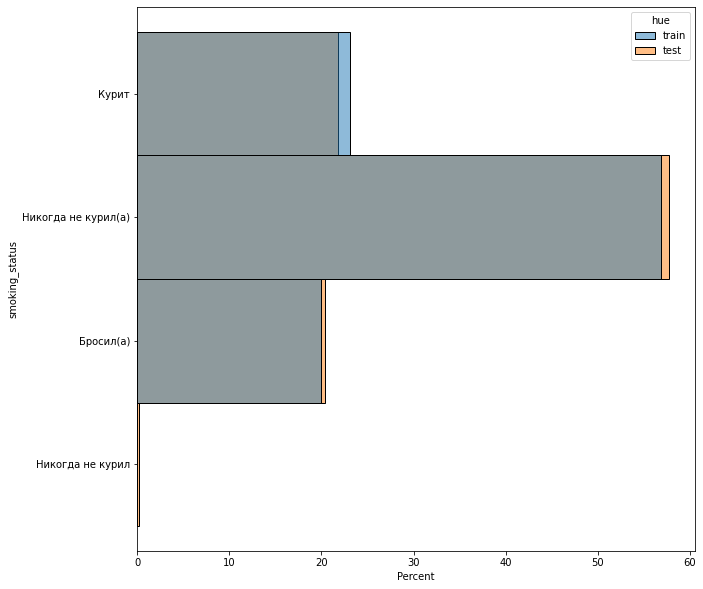

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
col = 'smoking_status'
sns.histplot(
    data=pd.concat([
        train[[col]].assign(hue='train'),
        test[[col]].assign(hue='test'),
        ]),
    y=col,
    common_bins=False, 
    common_norm=False,
    stat='percent',
    hue='hue')